# Background

## Objective

I recently found a group of friends to watch horror movies with. Despite our similar interests, it takes us forever to pick a movie every time. One can only imagine it getting harder for groups with more diverse interests. To make movie nights more fun and easier, I want to **build a recommender system recommends movies a group of users would enjoy**.

This project is a prototype of such a group movie recommender. I envision the full-fledge product either being a stand-alone application or integrated with streaming services such as Netflix, Hulu, Prime Video, etc.

## Dataset

[MovieLens](https://grouplens.org/datasets/movielens/) and the [Netflix Prize Data](https://www.kaggle.com/netflix-inc/netflix-prize-data) are the two most popular datasets for building movie recommender systems. Both are publicly available and use **explicit** (0 to 5 stars) as opposed to implicit (e.g., click, view, or purchase) ratings. The Netflix data is much older, with movies released between 1998 and 2005, whereas the MovieLens data was updated in December, 2019. To make more up-to-date recommendations for a broader audience, I'll build my recommender system on the MovieLens data. Due to training time concerns, I'll use the version with 10 thousand rather than 2.5 million user ratings.

## Approaches

Apparently, most users only rated a small subset of the movies in the dataset. To make recommendations is to solve the "rating prediction problem": **How would each user rate movie, whether or not they have seen it?**

<figure>
  <img src="img/sparse_matrix.png" width="400">
  <figcaption>
      A sparse matrix with mostly missing ratings (from <a href="http://nicolas-hug.com/blog/matrix_facto_1">Nicolas Hug's blog</a>).
    </figcaption>
</figure>

We can use a variety of information filtering algorithms to solve this problem, most of which fall under three categories:
- **Content filtering**: Make recommendations based on item features (e.g., genre, year, director, actor, etc.) or user features (e.g., age, gender, race/ethnicity, etc.).
- **Collaborative filtering**: Make recommendations based on user-item interactions (e.g., how users rate movies).
- **Hybrid approach**: Make recommendations based on both of the above.

No matter which algorithm we use, in the end movies with the highest predicted ratings will be recommended to the user. Compared to content filtering, collaborative filtering requires much less information (i.e., no need to specify user or item features) but generally achieves stronger results. Of course, it's more ideal if we can combine user/item features with historical interactions. 

As a good starting place, I will use collaborative filtering for this project. In the future, we can add user/item features to improve the system. One of the best-performing algorithm for collaborative filtering is [singular value decomposition (SVD)](http://nicolas-hug.com/blog/matrix_facto_2), which is illustrated below:


<figure>
  <img src="img/svd.png" width="500">
  <figcaption>
      Illustration of SVD (from <a href="http://nicolas-hug.com/blog/matrix_facto_2">Nicolas Hug's blog</a>).
    </figcaption>
</figure>

SVD factorizes the user-item matrix $R$ into three smaller matrices: A user-feature matrix $M$, a transposed item-feature matrix $U^{T}$, and a diagonal matrix $\Sigma$ used for scaling ($R = M\Sigma U^{T}$). Here, "features" are not explicitly defined like in content filtering but rather latent features discovered from user-item interactions. SVD in the real sense only works on complete matrices but not matrices with missing ratings. In this context, "SVD" refers to SVD-inspired algorithms that find factorization via gradient descent or other optimization processes. SVD++ is an extension of SVD that takes account of the fact that a user rated some movies but not others. SVD++ is the best performer in many datasets.

## Evaluation
How do we know if a recommender system is any good? 

The most straightforward way is to hold out part of the rating matrix and compare SVD predictions with actual user ratings using metrics such as root-mean-square error (RMSE), mean absolute error (MAE), etc. Since RMSE is fairly easy to compute, I'll use it for hyperparameter tuning. However, considering that only the top few items get recommended, it doesn't matter how well a recommender system predicts ratings of mediocre items that may never see the light of the day. A more relevant measure is how well the system predicts each user's top K items, such as **Precision@k** and **Recall@k**. By averaging Precision@k and Recall@k across all users, we can use the Mean Average Precision@k (**MAP@K**) and the Mean Average Recalln@k (**MAR@K**) to measure the performance of the entire system.

Aside from accuracy, it's also important that a recommender makes diverse and personalize recommendations. For instance, it's not very useful if recommended items are too similar (users can discover the rest on their own), such as 9 Star War movies in a row, even though each movie may be rated highly. Also, if everyone is recommended the same set of hyper popular items, there is no opportunity for users to enjoy serendipitous discoveries and for the system to learn about each user's unique taste. To address these concerns, we can examine similarity both among items recommended to the same user (**intra-list similarity**) and across items recommended to different users (**personalization**). Coverage is another popular metric for recommender systems, which captures out of all the movies in the catalog, what percentage can be recommended. Again, a popularity-based recommender always sticks to the few go-to movies and therefore has a super low Coverage. A random recommender, however, may cover 100% of the movies. A useful recommender should be able to recommend a fair proportion of the movies without being indiscriminate.

I will use RMSE to tune hyperparameters since it's the fastest and most straightforward to compute. Then I'll use each of the 6 metrics above (RMSE, MAP@K, MAR@K, Intra-list similarity, Personalization, and Coverage) to evaluate the recommender's performance in the test set.

# Prepare data

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np

np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sklearn.model_selection
import surprise.model_selection
from surprise import accuracy
from surprise import Dataset, Reader, SVDpp, NormalPredictor, BaselineOnly
from surprise import dump
from surprise.model_selection import GridSearchCV
import recmetrics

sns.set_context("notebook", font_scale=1.3)
sns.set_palette("tab10")

%load_ext lab_black

## Load data

In [2]:
# Load rating and movie data
data_df = pd.read_csv("ml-latest-small/ratings.csv")

movies_df = pd.read_csv("ml-latest-small/movies.csv")

## Split data
To avoid data leakage, I'm splitting the data into three different sets: The validation set for hyperparameter tuning, the training set for modeling training, and the testing set for model evaluation. 

In [3]:
# Save 20% of the data for hyperparameter tuning
validation_df, rest_df = sklearn.model_selection.train_test_split(
    data_df, test_size=0.2
)

# Convert DataFrame to Reader objects
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(data_df[["userId", "movieId", "rating"]], reader)

validation = Dataset.load_from_df(
    validation_df[["userId", "movieId", "rating"]], reader
)

rest = Dataset.load_from_df(rest_df[["userId", "movieId", "rating"]], reader)

# Save 20% of the data for testing
train, test = surprise.model_selection.train_test_split(rest, test_size=0.2)

## Exploratory data analysis

### Average ratings

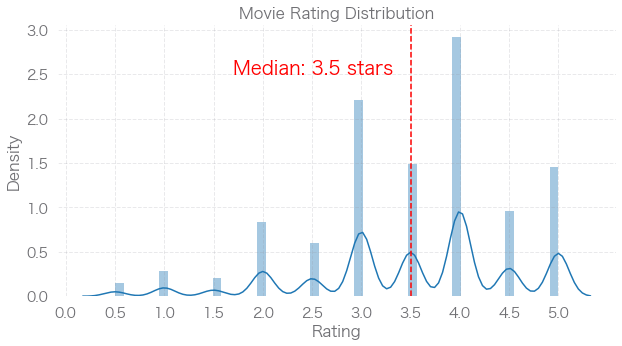

In [4]:
# Density plot of ratings
plt.figure(figsize=(10, 5))
sns.distplot(rest_df["rating"])
plt.axvline(rest_df["rating"].median(), color="r", linestyle="--")
plt.title("Movie Rating Distribution")
plt.xlabel("Rating")
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.ylabel("Density")
plt.text(
    rest_df["rating"].median() - 1.8,
    2.5,
    f'Median: {rest_df["rating"].median()} stars',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

MovieLens uses a scale from 0 to 5 stars with half-star increments. The rating distribution is skewed to the left, with most movies rated highly (3.5 stars or above). This makes sense because users may be more motivated to rate movies they liked or just remember them better to give ratings a while after viewing.

### Number of ratings

#### Per movie

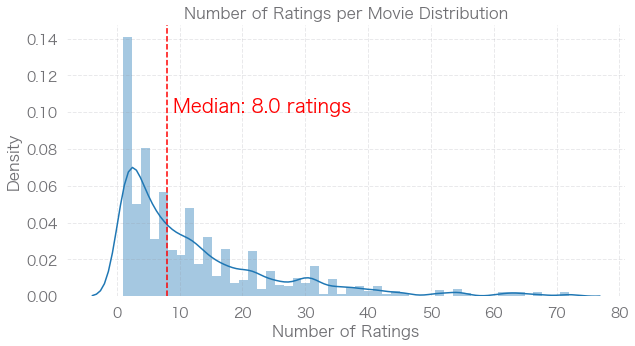

In [5]:
# Count the number of ratings received by each movie
num_ratings_movie = pd.DataFrame(
    rest_df.groupby("movieId").count()["rating"]
).reset_index()

# Add this information to the original data frame
df_movie_num = pd.merge(left=rest_df, right=num_ratings_movie, on="movieId")
df_movie_num.rename(
    columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True
)

# Density plot of the number of ratings
plt.figure(figsize=(10, 5))
sns.distplot(df_movie_num["numRatings"])
plt.axvline(df_movie_num["numRatings"].median(), color="r", linestyle="--")
plt.title("Number of Ratings per Movie Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.text(
    df_movie_num["numRatings"].median() + 1,
    0.1,
    f'Median: {df_movie_num["numRatings"].median()} ratings',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

Most movies received fewer than 8 ratings whereas some received as many as 70. As is often the case in collaborative filtering, among movies with similar ratings, the ones that are more popular will be more likely to get recommended.

#### Per user

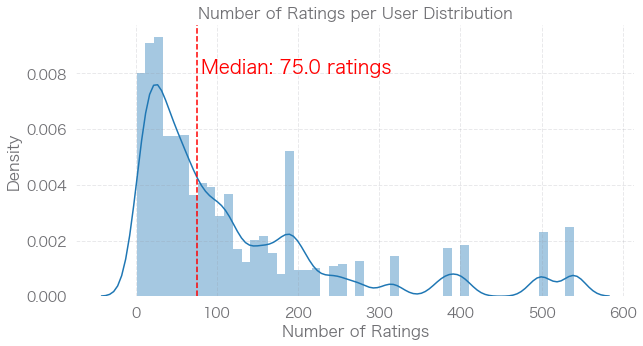

In [6]:
# Count the number of ratings given by each user
num_ratings_user = pd.DataFrame(
    rest_df.groupby("userId").count()["rating"]
).reset_index()

# Add this information to the original data frame
df_user_num = pd.merge(left=rest_df, right=num_ratings_user, on="userId")
df_user_num.rename(
    columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True
)

# Density plot of the number of ratings
plt.figure(figsize=(10, 5))
sns.distplot(df_user_num["numRatings"])
plt.axvline(df_user_num["numRatings"].median(), color="r", linestyle="--")
plt.title("Number of Ratings per User Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.text(
    df_user_num["numRatings"].median() + 5,
    0.008,
    f'Median: {df_user_num["numRatings"].median()} ratings',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

MovieLens users really rated quite a lot of movies, with the median being 74 ratings per user and the maximum above 500. The relative high density is one of the reasons why MovieLens is great for building movie recommenders. 

### Number of ratings per movie vs. rating

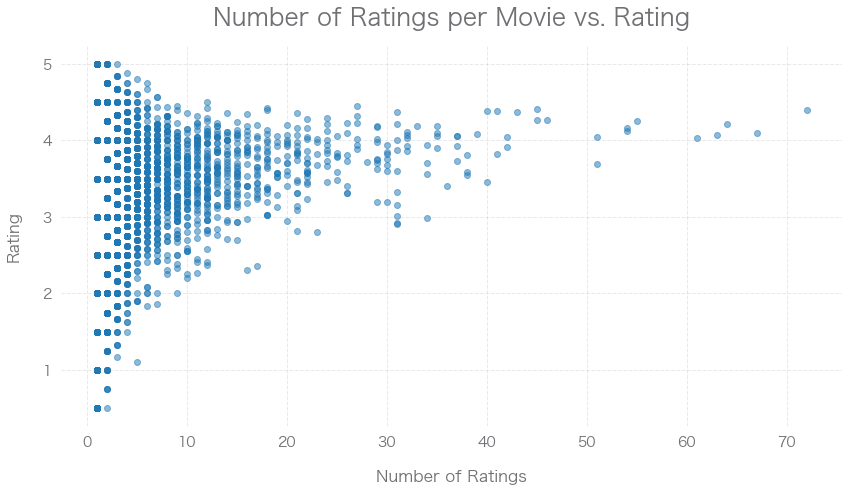

In [7]:
# Extract the average rating of each movie and the number of ratings it received
ratings_movie = pd.DataFrame()
ratings_movie["meanRating"] = df_movie_num.groupby("movieId")["rating"].mean().values
ratings_movie["numRatings"] = df_movie_num.groupby("movieId")["rating"].count().values

# Plot number of ratings per movie vs. rating
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Number of Ratings per Movie vs. Rating", fontsize=24, pad=20)
ax.set_xlabel("Number of Ratings", fontsize=16, labelpad=20)
ax.set_ylabel("Rating", fontsize=16, labelpad=20)

plt.scatter(ratings_movie["numRatings"], ratings_movie["meanRating"], alpha=0.5)
plt.show()

A common complaints about collaborative filtering is that it likes to recommend popular items. However, this may not so bad since popular movies tend to be highly rated. After all, these movies are popular for a reason. So even though *The Shawshank Redemption* may seem like a cliché, it is nonetheless a safe option for someone who's never watched it.

# Build a recommender

## Model tuning
First, let's find the optimal value of each hyperparameter before training. Since training SVD++ is computationally expensive and takes a long time, we'd better not get greedy and just focus on two hyperparameters: `lr_all` (the learning rate for all parameters) and `reg_all` (the regularization term for all parameters).

In [8]:
# Define the hyperparameter space
param_grid = {"lr_all": [0.005, 0.01], "reg_all": [0.02, 0.1]}

# Use grid search to find the best SVD++ estimator
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse"], n_jobs=-1, cv=3)

gs.fit(validation)

algo = gs.best_estimator["rmse"]

## Model training
Next, let's train the model on the training data and save the trained model for later use. 

In [9]:
# Train the algorithm on the train set
algo.fit(train)

# Save the model
dump.dump("best_svd", algo=algo)

## Model evaluation
With the completed rating matrix, we can make predictions for any user in the system. As discussed before, we can use a variety of metrics (see this [Medium article](https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093) for a comprehensive review and [this notebook](https://github.com/statisticianinstilettos/recmetrics/blob/master/example.ipynb) for their implementations) to check if the system makes accurate, diverse, and personalized recommendations.

However, these metrics alone can't tell us if the system is good or not; we need baseline algorithms to compare it to. Below I'll use two baseline models from the `Surprise` library: `NormalPredictor` and `BaselineOnly`. The former predicts a random rating based on the distribution (assumed to be normal) of the training set. The latter make predictions based on each user's average rating across all movies and each movie's rating across all users.

In [10]:
# Load trained model
_, svdtuned = dump.load("best_svd")

In [11]:
# Use SVD++ to make predictions
svd_preds = svdtuned.test(test)

# Use NormalPredictor to make predictions
normal = NormalPredictor()
normal.fit(train)
normal_preds = normal.test(test)

# Use BaselineOnly to make predictions
baseline = BaselineOnly()
baseline.fit(train)
baseline_preds = baseline.test(test)

Estimating biases using als...


In [12]:
# Create a new data frame to save SVD++ predictions
df_preds = pd.DataFrame(svd_preds)
df_preds.drop("details", inplace=True, axis=1)
df_preds.columns = ["userId", "movieId", "actual_rating", "svd_prediction"]

# Add predictions by baseline models
df_preds["normal_prediction"] = pd.DataFrame(normal_preds)["est"]
df_preds["baseline_prediction"] = pd.DataFrame(baseline_preds)["est"]

# Have a look
df_preds.head()

,userId,movieId,actual_rating,svd_prediction,normal_prediction,baseline_prediction
0,509,7147,3.0,3.187757,2.539369,3.231087
1,297,1358,4.0,2.320432,4.057448,2.747497
2,239,49530,4.0,4.189482,3.316008,4.077212
3,448,6888,1.5,2.185435,2.659765,2.580255
4,184,105653,4.0,3.946571,4.157258,3.797591


### RMSE
RMSE measures the global accuracy of a recommender system's rating predictions. We can compute RMSE for all three models.

In [13]:
# List of model names
model_list = ["svd", "normal", "baseline"]

# Save RMSE results in a data frame
df_eval = pd.DataFrame()
df_eval["model"] = model_list
df_eval["RMSE"] = [
    recmetrics.rmse(df_preds["actual_rating"], df_preds[f"{model}_prediction"])
    for model in model_list
]

# Display results
df_eval

,model,RMSE
0,svd,0.915999
1,normal,1.418214
2,baseline,0.921982


RMSE of SVD++ is the lowest among three, meaning that it predicts ratings most accurately.

### MAP@K and MAR@K

Movies whose ratings are below some threshold (3.5 starts) are irrelevant in that they may never get recommended to a user. Considering only movies with K highest ratings, Precision@K measures out of items recommended to each user, how many are relevant (i.e., above the threshold). Recall@K measures out of items relevant to each user, how many get recommended. By averaging the two metrics across all users, we get MAP@K and MAR@K. The function used to calculate Precision@K and Recall@K is taken from the [Surprise documentation](https://surprise.readthedocs.io/en/stable/FAQ.html).

In [14]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return Precision@K and  Recall@K for each user"""

    # Map predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

Based on the function above, we can write a new one to calculate MAP@K and  MAR@K.

In [15]:
def mapk_mark_at_k(model_preds, k=10, threshold=3.5):
    """Return MAP@K and  MAR@K for the recommender system"""

    # Get Precision@K and Recall@K for each user
    precisions, recalls = precision_recall_at_k(model_preds, k, threshold)

    # Calculate MAP@K and MAR@K by averaging across users
    mapk, mark = (np.mean(list(precisions.values())), np.mean(list(recalls.values())))

    return mapk, mark

In [16]:
# List of model predictions
preds_list = [svd_preds, normal_preds, baseline_preds]

# Collect results
df_eval["MAP@K"] = [mapk_mark_at_k(preds, 10, 3.5)[0] for preds in preds_list]
df_eval["MAR@K"] = [mapk_mark_at_k(preds, 10, 3.5)[1] for preds in preds_list]

# Show new comparisons
df_eval

,model,RMSE,MAP@K,MAR@K
0,svd,0.915999,0.795045,0.695098
1,normal,1.418214,0.708941,0.551866
2,baseline,0.921982,0.791606,0.706890


SVD++ has higher MAP@K and MAR@K than either baseline, suggesting that its advantage extends to highly rated items.

### Intra-list similarity
Intra-list similarity is the average cosine similarity of all items in each user's list of recommendations. Similarity of calculated based on ranking so we first need to extract each user's movie ranking.

In [17]:
def user_ranking(uid, model):
    """Return a list of each user's movie ranking"""

    # List of movie rated by the given user
    movie_list = df_preds.loc[df_preds["userId"] == uid, "movieId"]

    # List of ratings predicted by the given model
    rating_list = df_preds.loc[df_preds["userId"] == uid, f"{model}_prediction"]

    # Sort movie by rating and return movie list
    return [movie for _, movie in sorted(zip(rating_list, movie_list))]

In [18]:
# Create a new data frame for movie rankings
df_rankings = pd.DataFrame()
df_rankings["userId"] = df_preds["userId"].unique()

# Rank movies by each model prediction
for model in model_list:
    df_rankings[f"{model}_ranking"] = df_rankings["userId"].apply(
        lambda x: user_ranking(x, model)
    )

# Show results
df_rankings.head()

,userId,svd_ranking,normal_ranking,baseline_ranking
0,509,"[5313, 104841, 1665, 87485, 1033, 50685, 92509...","[60069, 87485, 50685, 4886, 7147, 38038, 8972,...","[5313, 104841, 1665, 87485, 1033, 8972, 103042..."
1,297,"[1556, 1358, 1343]","[1358, 1343, 1556]","[1556, 1358, 1343]"
2,239,"[2699, 8529, 41566, 52722, 61350, 595, 1676, 5...","[595, 16, 4022, 2699, 49530, 41566, 51662, 357...","[2699, 41566, 8529, 52722, 61350, 1676, 595, 5..."
3,448,"[6564, 6888, 5449, 2153, 30825, 432, 45221, 20...","[7016, 5462, 105213, 59784, 87785, 49278, 802,...","[6564, 6888, 432, 5449, 30793, 2088, 2153, 452..."
4,184,"[70533, 105653, 122922, 148978, 158035, 173235...","[173235, 142488, 106782, 48780, 148978, 168250...","[70533, 105653, 122922, 148978, 158035, 173235..."


Calculating intra-list similarity requires another data frame where each row is a movie and each column is feature of the movie, such as whether it belongs to a certain genre. Let's create that data frame below.

In [19]:
# Identify unique genres
genres = [genre.split("|") for genre in movies_df["genres"].dropna()]
genres = [item for sublist in genres for item in sublist]
genre_list = pd.Series(genres).unique().tolist()

# One-hot encode genres
df_features = pd.DataFrame()
for genre in genre_list:
    df_features[genre] = movies_df["genres"].apply(
        lambda x: 1 if genre in str(x) else 0
    )

df_features.index = movies_df["movieId"]

# Drop meaningless genres
df_features.drop(["IMAX", "(no genres listed)"], axis=1, inplace=True)

Then we can calculate intra-list similarity.

In [20]:
# Add Personalization scores the data frame
df_eval["ILS"] = [
    recmetrics.intra_list_similarity(
        df_rankings[f"{model}_ranking"].tolist(), df_features
    )
    for model in model_list
]

# Show new comparisons
df_eval

,model,RMSE,MAP@K,MAR@K,ILS
0,svd,0.915999,0.795045,0.695098,0.243576
1,normal,1.418214,0.708941,0.551866,0.243576
2,baseline,0.921982,0.791606,0.706890,0.243576


The intra-list similarity is the same for all models and it's quite slow, suggesting that users get reasonably diverse recommendations.

### Personalization
Personalization measures the dissimilarity (1 - cosine similarity) between different users' lists of recommendations.

In [21]:
# Add Personalization scores the data frame
df_eval["Personalization"] = [
    recmetrics.personalization(predicted=df_rankings[f"{model}_ranking"].tolist())
    for model in model_list
]

# Show results
df_eval

,model,RMSE,MAP@K,MAR@K,ILS,Personalization
0,svd,0.915999,0.795045,0.695098,0.243576,0.995616
1,normal,1.418214,0.708941,0.551866,0.243576,0.995616
2,baseline,0.921982,0.791606,0.706890,0.243576,0.995616


Personalization is also the same for all models and it's very high, suggesting that different users get different recommendations. That is, recommendations are highly personalized regardless of the algorithm used.

### Coverage
Lastly, let's look out of all movies in the system, what percentage can get recommended.

In [22]:
def prediction_coverage(rec_list, catalog):
    """Calcuate % of movies covered by recommendations"""

    rec_list_flat = [item for sublist in rec_list for item in sublist]
    unique_recs = len(set(rec_list_flat))
    prediction_coverage = round(unique_recs / (len(catalog) * 1.0) * 100, 2)
    return prediction_coverage

In [23]:
# All movies ID's
catalog = movies_df["movieId"].unique().tolist()

# Coverage of each model
df_eval["coverage"] = [
    prediction_coverage(df_rankings[f"{model}_ranking"], catalog)
    for model in model_list
]

# Show results
df_eval

,model,RMSE,MAP@K,MAR@K,ILS,Personalization,coverage
0,svd,0.915999,0.795045,0.695098,0.243576,0.995616,22.54
1,normal,1.418214,0.708941,0.551866,0.243576,0.995616,22.54
2,baseline,0.921982,0.791606,0.706890,0.243576,0.995616,22.54


All three algorithms have the coverage, which is pretty high (over 20%).